<a href="https://colab.research.google.com/github/saideep3/Test/blob/master/1105142_1dconv_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


In [275]:
from google.colab import drive
drive.mount('/content/drive')

#Reading dataset from Google drive
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/housing.csv')
dataset = dataset.dropna()

#Printing first 10 rows of the dataset
dataset.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


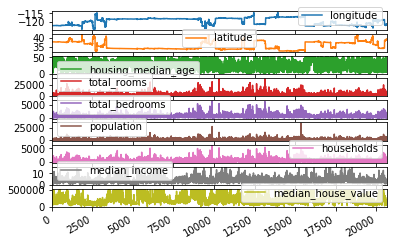

<Figure size 432x288 with 0 Axes>

In [276]:
import matplotlib.pyplot as plt
dataset.plot(subplots=True)
fig = plt.figure()
plt.tight_layout()
plt.show()

In [0]:
#retrieving dependent and independent variables
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']

In [0]:
#Test and train split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2003)

#converting values to numpy array
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

#performning standardization on independent variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(x_train_np)
X_test = sc.transform(x_test_np)


In [0]:
#importing libraries
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset 

In [0]:


class CnnRegressor(torch.nn.Module):

#initializing network
   def __init__(self, batch_size, inputs, outputs):

     super(CnnRegressor, self).__init__()
     self.batch_size = batch_size
     self.inputs = inputs
     self.outputs = outputs

     #input convolution with kernel 3 and padding 1
     self.input_layer = Conv1d(inputs, batch_size, 3, padding=1)

     #adding max pool layer
     self.max_pooling_layer = MaxPool1d(3,padding=1)

     #self.conv_layer = Conv1d(batch_size, 128)
     self.conv_layer = Conv1d(batch_size, 128, 3,padding=1)



    #flatten layer
     self.flatten_layer = Flatten()

      #defining linear layer
     self.linear_layer = Linear(128, 64)
     
     #output layer
     self.output_layer = Linear(64, outputs)
     
     #feed foreward n/w
   def feed(self, input):

    input = input.reshape((self.batch_size, self.inputs, 1))
    #adding ReLu activation
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    #convolution layer
    output = relu(self.conv_layer(output))
    output = self.max_pooling_layer(output)
    #convolution layer
    output = relu(self.conv_layer(output))
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
  
# Finally, get the output of the output layer and return it
    output = self.output_layer(output)
    return output

In [281]:
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [282]:
#defining batch size
batch_size = 128
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count= 0
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_score += score 
    count += 1
  return avg_loss / count, avg_score / count

Epoch 1:
	loss = 138327.75548986485
	R^2 score = -2.3480892511254803
Epoch 2:
	loss = 107879.11387950451
	R^2 score = -0.9167114962072911
Epoch 3:
	loss = 85098.71593468469
	R^2 score = -0.1362915207934719
Epoch 4:
	loss = 79295.69717764639
	R^2 score = 0.17577931785717105
Epoch 5:
	loss = 77708.7421875
	R^2 score = 0.21793958827429347
Epoch 6:
	loss = 77049.19619228604
	R^2 score = 0.22685517850091735
Epoch 7:
	loss = 75771.78357263513
	R^2 score = 0.24473269671132433
Epoch 8:
	loss = 73317.55264639639
	R^2 score = 0.2965151173427584
Epoch 9:
	loss = 71569.69629786036
	R^2 score = 0.31688545783779765
Epoch 10:
	loss = 69978.80922719595
	R^2 score = 0.36169428600392123
Epoch 11:
	loss = 67180.2666455518
	R^2 score = 0.39657984678003344
Epoch 12:
	loss = 66970.64745213964
	R^2 score = 0.43360163053890105
Epoch 13:
	loss = 65423.059719876124
	R^2 score = 0.4127336535564944
Epoch 14:
	loss = 63964.34554476351
	R^2 score = 0.43996930917008337
Epoch 15:
	loss = 62865.90463119369
	R^2 score 

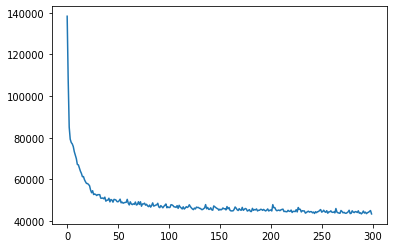

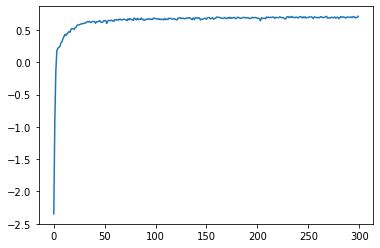

In [284]:
#Defining number of epochs
epochs = 300
#adding the optimizer
optimizer= torch.optim.Adam(model.parameters(), lr=1e-3)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
loss = []
r2 = []
for epoch in range(epochs):
   avg_loss, avg_r2_score = model_loss(model, loader , train=True, optimizer=optimizer)
   loss.append(avg_loss)
   r2.append(avg_r2_score)
   print("Epoch " + str(epoch + 1) + ":\n\tloss = " + str(avg_loss) + "\n\tR^2 score = " + str(avg_r2_score))


#Plotting the graphs of L1 score and R^2Score
import matplotlib.pyplot as plt
plt.plot(loss)
plt.show()

plt.plot(r2)
plt.show()


In [285]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 45067.911569148935
The model's R^2 score is: 0.7021143079902217
